In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

torch.manual_seed(27)
device = torch.device("cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

training_DataLoader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testing_DataLoader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [3]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.Dense1 = nn.Linear(28*28, 64)
        self.Dense2 = nn.Linear(64, 32)
        self.Dense3 = nn.Linear(32, 10)

    def forward(self, inputData):
        inputData = inputData.view(inputData.shape[0], -1)
        inputData = F.relu(self.Dense1(inputData))
        inputData = F.relu(self.Dense2(inputData))
        inputData = self.Dense3(inputData)
        return inputData


In [4]:
def train(model, optimizer, train_loader):
    model.train()
    train_loss = []
    train_acc = []
    collected_weights_layer1 = []
    collected_weights_whole = []
    loss_func = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 25):
        correct = 0
        total_samples = 0
        epoch_loss = 0

        for i, (images, labels) in enumerate(train_loader):
            output = model(images)
            loss = loss_func(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = output.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        avg_acc = correct / total_samples

        if epoch % 3 == 0:
            with torch.no_grad():
                layer1_weights = []
                whole_weights = []
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        whole_weights.append(param.detach().numpy().ravel())
                        if 'Dense1' in name:
                            layer1_weights.append(param.detach().numpy().ravel())
                collected_weights_layer1.append(np.concatenate(layer1_weights))
                collected_weights_whole.append(np.concatenate(whole_weights))

        train_loss.append(avg_loss)
        train_acc.append(avg_acc)
        print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc * 100:.2f}%')

    return train_loss, train_acc, collected_weights_layer1, collected_weights_whole

In [5]:
def apply_pca(weights):
    weights_matrix = np.array(weights)
    print(weights_matrix.shape)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(weights_matrix)
    return pca_result

In [6]:
layer_1_pca = []
whole_pca = []
train_acc_arr = []
train_loss_arr = []

for trainingIndex in range(1,9):
    model = DNNModel().to(device)
    optimizer1 = optim.Adam(model.parameters(), lr=1e-4)
    train_loss, train_acc, layer1_weights, whole_weights = train(model, optimizer1, training_DataLoader)

    pca_out_layer1 = apply_pca(layer1_weights)
    pca_out_whole = apply_pca(whole_weights)
    
    layer_1_pca.append(pca_out_layer1)
    whole_pca.append(pca_out_whole)
    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)


Epoch 1, Loss: 0.7943, Accuracy: 80.06%
Epoch 2, Loss: 0.3304, Accuracy: 90.57%
Epoch 3, Loss: 0.2757, Accuracy: 92.01%
Epoch 4, Loss: 0.2424, Accuracy: 93.01%
Epoch 5, Loss: 0.2174, Accuracy: 93.76%
Epoch 6, Loss: 0.1975, Accuracy: 94.46%
Epoch 7, Loss: 0.1812, Accuracy: 94.83%
Epoch 8, Loss: 0.1675, Accuracy: 95.18%
Epoch 9, Loss: 0.1558, Accuracy: 95.51%
Epoch 10, Loss: 0.1453, Accuracy: 95.84%
Epoch 11, Loss: 0.1365, Accuracy: 96.06%
Epoch 12, Loss: 0.1280, Accuracy: 96.30%
Epoch 13, Loss: 0.1212, Accuracy: 96.51%
Epoch 14, Loss: 0.1148, Accuracy: 96.64%
Epoch 15, Loss: 0.1086, Accuracy: 96.88%
Epoch 16, Loss: 0.1032, Accuracy: 97.01%
Epoch 17, Loss: 0.0981, Accuracy: 97.12%
Epoch 18, Loss: 0.0930, Accuracy: 97.30%
Epoch 19, Loss: 0.0890, Accuracy: 97.39%
Epoch 20, Loss: 0.0849, Accuracy: 97.52%
Epoch 21, Loss: 0.0813, Accuracy: 97.61%
Epoch 22, Loss: 0.0774, Accuracy: 97.77%
Epoch 23, Loss: 0.0741, Accuracy: 97.87%
Epoch 24, Loss: 0.0713, Accuracy: 97.90%
(8, 50176)
(8, 52544)
Epo

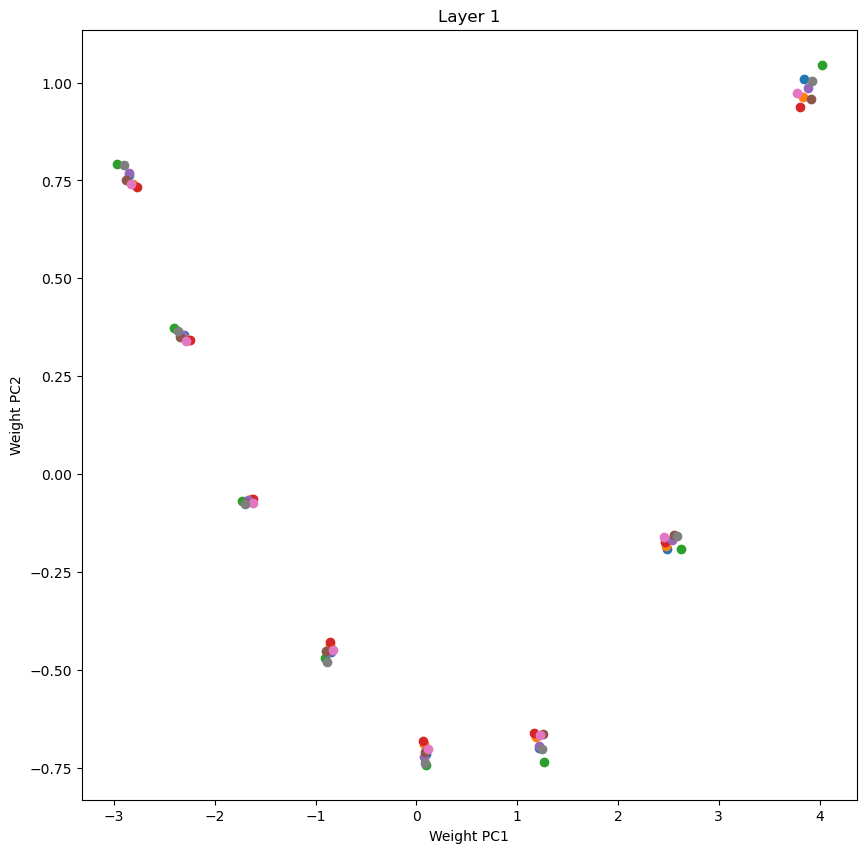

In [11]:
plt.figure(figsize=(10, 10))
plt.xlabel('Weight PC1')
plt.ylabel('Weight PC2')
plt.title('Layer 1')
for i in range(len(layer_1_pca)):
    W_i = layer_1_pca[i]
    plt.scatter(W_i[:, 0], W_i[:, 1])

plt.show()



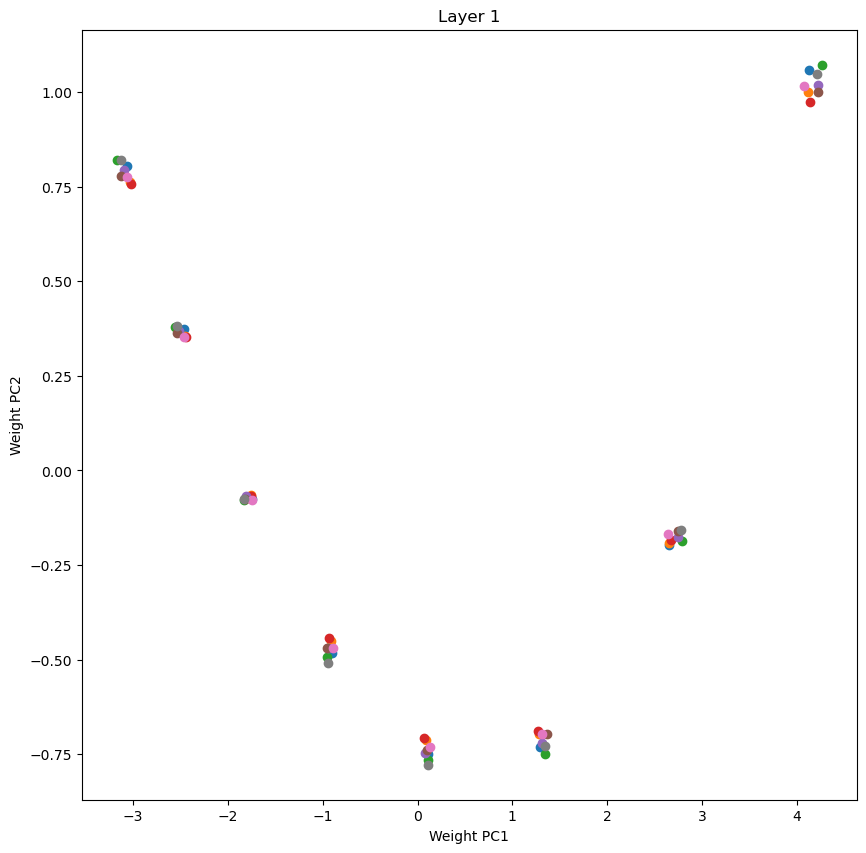

In [13]:
plt.figure(figsize=(10, 10))
plt.xlabel('Weight PC1')
plt.ylabel('Weight PC2')
plt.title('Layer 1')
for i in range(len(whole_pca)):
    W_i = whole_pca[i]
    plt.scatter(W_i[:, 0], W_i[:, 1])

plt.show()